<a href="https://colab.research.google.com/github/Dhrumil2910/Diamond-Distance-and-Infidelity-SDPs/blob/main/Homework5_QIT_Course_Mark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from qutipy import *
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def normalized_diam_distance(gamma, N):
  # channels
  gadc = generalized_amplitude_damping_channel(gamma, N)
  identity_channel = Pauli_channel(0, 0, 0)

  # Their Choi representations
  choi_gadc = Choi_representation(gadc, 2)
  choi_identity = Choi_representation(identity_channel[0], 2)

  # Difference between two choi operators
  diff = choi_identity - choi_gadc
  delta_choi = (diff.conj().T + diff) / 2

  # find normalized diamond distance using cvxpy

  # define variables involved in the SDP
  W = cvx.Variable((4,4), complex=True)
  constraints = [W == W.H]
  constraints += [W >> 0]
  
  rho = cvx.Variable((2,2), complex=True)
  constraints += [rho == rho.H]
  constraints += [rho >> 0]
  constraints += [cvx.trace(rho) == 1]
  
  constraints += [(W - cvx.kron(np.eye(2), rho)) << 0]
  
  J = cvx.Parameter([4, 4], complex=True)
  
  # define the objective function
  objective = cvx.Maximize(cvx.real(cvx.trace(J.H * W)))
  
  # define the problem
  prob = cvx.Problem(objective, constraints)
  
  J.value = delta_choi
  
  return prob.solve()

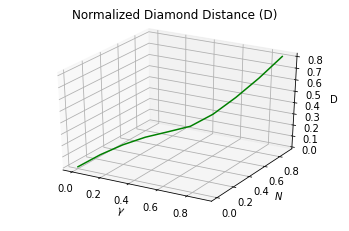

In [20]:
# plot the diamond distance
gamma_values = np.arange(0, 1, 0.1)
N_values = np.arange(0, 1, 0.1)

vecfunc = np.vectorize(normalized_diam_distance)
T = vecfunc(gamma_values, N_values)

fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

ax.plot3D(gamma_values, N_values, T, 'green')
ax.set_title('Normalized Diamond Distance (D)')
ax.set_xlabel('$\gamma$', rotation=150)
ax.set_ylabel('$N$')
ax.set_zlabel('D')
ax.dist = 11
plt.show()

In [45]:
def infidelity(gamma, N):
  # channels
  gadc = generalized_amplitude_damping_channel(gamma, N)
  identity_channel = Pauli_channel(0, 0, 0)

  # Their Choi representations
  choi_gadc = Choi_representation(gadc, 2)
  choi_identity = Choi_representation(identity_channel[0], 2)

  gadc_choi_Herm = (choi_gadc.conj().T + choi_gadc) / 2
  identity_choi_Herm = (choi_identity.conj().T + choi_identity) / 2

  rho = cvx.Variable((2,2), complex=True)
  constraint = [rho == rho.H]
  constraint += [rho >> 0]
  constraint += [cvx.trace(rho) == 1]
  
  W1 = cvx.Variable((4,4), complex=True)
  constraint += [W1 == W1.H]
  
  Z = cvx.Variable((4,4), complex=True)
  constraint += [Z == Z.H]

  mat = cvx.bmat([[W1, cvx.kron(np.eye(2), rho)], [cvx.kron(np.eye(2), rho), Z]])
  constraint += [mat >> 0]

  J1 = cvx.Parameter([4, 4], complex=True)

  J2 = cvx.Parameter([4, 4], complex=True)

  objective = cvx.Minimize(cvx.real(cvx.trace(J1.H * W1) + cvx.trace(J2.H * Z)))

  J1.value = gadc_choi_Herm
  J2.value = identity_choi_Herm

  prob = cvx.Problem(objective, constraint)

  r = prob.solve()

  infidelity_express = 1 - (r/2)**2

  return infidelity_express

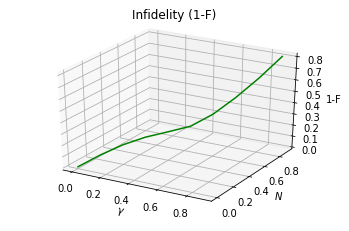

In [46]:
# plot the infidelity function
gamma_values = np.arange(0, 1, 0.1)
N_values = np.arange(0, 1, 0.1)

vecfunc = np.vectorize(infidelity)
T = vecfunc(gamma_values, N_values)

fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

ax.plot3D(gamma_values, N_values, T, 'green')
ax.set_title('Infidelity (1-F)')
ax.set_xlabel('$\gamma$', rotation=150)
ax.set_ylabel('$N$')
ax.set_zlabel('1-F')
ax.dist = 11
plt.show()

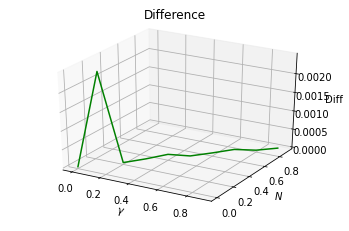

In [52]:
# plot the difference
gamma_values = np.arange(0, 1, 0.1)
N_values = np.arange(0, 1, 0.1)

vecfunc_in = np.vectorize(infidelity)
vecfunc_dd = np.vectorize(normalized_diam_distance)
T1 = vecfunc_in(gamma_values, N_values)
T2 = vecfunc_dd(gamma_values, N_values)
T = T2 - T1
fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

ax.plot3D(gamma_values, N_values, T, 'green')
ax.set_title('Difference')
ax.set_xlabel('$\gamma$', rotation=150)
ax.set_ylabel('$N$')
ax.set_zlabel('Diff')
ax.dist = 11
plt.show()